## Final Project Submission

Please fill out:
* Student name: Erica Gabriel, Kimberely & Saeed Akbar (Zedd)
* Student pace: Full time
* Scheduled project review date/time: 06/05/2020 @ 2:00 PM CST
* Instructor name: Rafael Carrasco
* Blog post URL:



## The Whole process if followed by OSMIN process

# Obtaining the Data

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE

In [2]:
#Loading the Dataset
data = pd.read_csv('kc_house_data.csv')
df = pd.DataFrame(data)
df.head() #Display first 5 rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Checking for all the null values,
# Info of the dataset
# Unique values of each column
# and verifying the duplicate column in the entire dataset

print(df.isnull().sum(),'\n\n')
print(df.info(),'\n\n')
print(df.nunique())
print(df[df.duplicated()])

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597

# Scrubbing and Cleaning Data

In [4]:
df['waterfront'] = df['waterfront'].fillna(0.0) 
#Fill null values with median value
df['yr_renovated'] = df['yr_renovated'].fillna(0.0) 
#Fill null values with median value
df['sqft_basement'] = df.sqft_basement.replace('?','0.0')  
# Replacing the '?' with the 0.00


In [5]:
# Columns that are dropped that will assist in deriving our end goal

df = df.drop(['lat', 'long', 'sqft_living15', 'sqft_lot15', 'id','view'], axis=1)

In [6]:
#Converting the Datetime Frame into a proper datetime object
df['date'] = df['date'].astype('datetime64[ns]') 
#Converting the 'sqft_basement' from object to a float datatype
df['sqft_basement'] = df['sqft_basement'].astype('float64')

In [7]:
#Converting the 'yr_renovated column' into a new binary data column
for index in df.yr_renovated:    
    if index == 0:
        df['is_renovated'] = 0.0
    elif index > 0:
        df['is_renovated'] = 1.0
df.loc[df['yr_renovated'] > 0.0 , 'is_renovated'] = 1.0

In [8]:
for index in df.sqft_basement:    
    if index == 0:
        df['b_sqft_basement'] = 0.0
    elif index > 0:
        df['b_sqft_basement'] = 1.0
df.loc[(df['sqft_basement'] > 0), 'b_sqft_basement'] = 1.0

In [9]:
#Outlier - 33 bedrooms, but 1.75 bath, and 1620 sqrt. Could be a typo
df = df.drop(15856, axis=0)

In [10]:
# Adding new columns for predictions in later derivations

df['month_sold'] = pd.DatetimeIndex(df['date']).month
df['yr_sold'] = pd.DatetimeIndex(df['date']).year

df['age'] = df['yr_sold'] - df['yr_built']
df['perc'] = (df['sqft_lot'] - (df['sqft_above'] / df['floors'])) / df['sqft_lot']

In [11]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,is_renovated,b_sqft_basement,month_sold,yr_sold,age,perc
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,0.0,1955,0.0,98178,0.0,0.0,10,2014,59,0.791150
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,400.0,1951,1991.0,98125,1.0,1.0,12,2014,63,0.850180
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,0.0,1933,0.0,98028,0.0,0.0,2,2015,82,0.923000
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,910.0,1965,0.0,98136,0.0,1.0,12,2014,49,0.790000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,0.0,1987,0.0,98074,0.0,0.0,2,2015,28,0.792079


In [12]:
# Identify the outliers 4 standard deviations away from mean in all columns
def remove_outliers(df, column_name, threshold=4):
    z_scores = stats.zscore(df[column_name])
    indices = np.abs(np.where(z_scores > threshold))
    return indices[0]
    
columns_to_check = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']

#['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode']
all_indices = []
for column in columns_to_check:
    indices = remove_outliers(df, column, threshold=3)
    all_indices.extend(indices)
all_indices = np.unique(all_indices)

# Remove outliers 4 standard deviations from mean in all columns
df = df.drop(index=all_indices)
df.shape

(20640, 21)

# Exploratory Data Analysis

### A Real Estate Company wants to help sellers decide a price to sell their homes in Kings County¶

1.What are the most/least expensive homes based on zipcodes (cheapest area to live in vs most expensive)?

2.What's the lowest grade/condition with the highest profit and vice versa?

3.Correlation/relationship between yr_built vs grade? (what age is considered vintage/"desirable old"?).


4.Whats the best month/time of year for buying and selling? (build model to predict year).

## 2.What's the lowest grade/condition with the highest profit and vice versa?


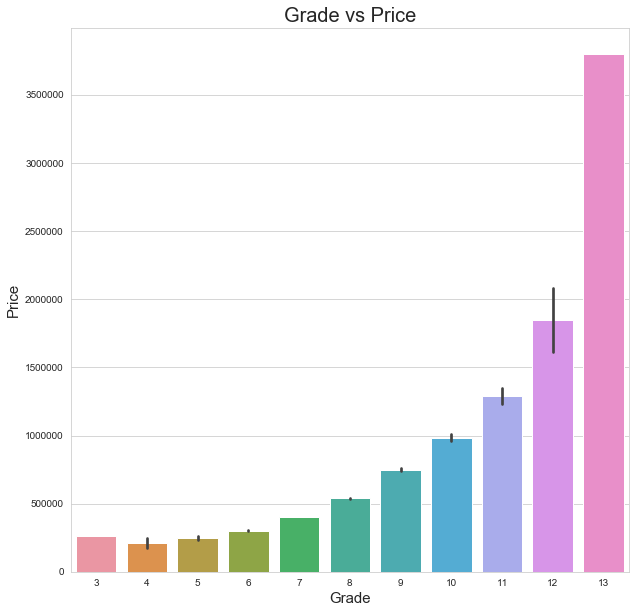

In [13]:
# Use sns.violinplot to plot year_built vs. grade
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
sns.barplot(x = "grade", y = "price", data=df)
plt.title('Grade vs Price', fontsize=20)
plt.xlabel('Grade', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
plt.show()

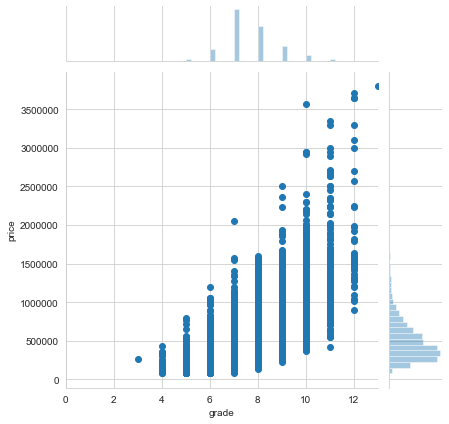

In [14]:
sns.jointplot(x = 'grade', y ='price',data =df,height=6, xlim=(0,13))

## Analysis of EDA

The violin plot and the joint plot plotted above derives clearly that there is clearly a great relationship between the "Grade" of the house and "Price". The houses that yield to the most of the least grade i.e grade 3 is about  260,000, where as when we compare with the Grade 12 house, they yield about 1,500,000 .This clearly depicts that as the grade of the houses goes higher the rate of price goes higher which inturns more profit through the sale of King County residential department.

In [15]:
#Visualizing the pairplot to see the linearity among the independent variables
# sns.pairplot(df)

In [16]:
print(df.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'is_renovated',
       'b_sqft_basement', 'month_sold', 'yr_sold', 'age', 'perc'],
      dtype='object')


In [17]:
# Dividing the columns into Continous and Categorical dataset for later use.
continuous = ['price','sqft_living', 'sqft_lot','sqft_above','sqft_basement', 'yr_built','date']
categorical = ['bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront','is_renovated'] 

In [18]:
#To check visually for the data to be categorical
# sns.pairplot(df[categorical])

In [19]:
#To check visually for the data to be categorical
# sns.pairplot(df[continuous])

In [20]:
#Highlighting the correlation among different independent variables
df_corr=df.corr().abs()

# Creating a function to highlight the correlation above the threshold value of 0.75
def Colli_thresh(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0.75 else 'black'
    return 'color: %s' % color

highlight_thresh = df_corr.style.applymap(Colli_thresh)
highlight_thresh

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,is_renovated,b_sqft_basement,month_sold,yr_sold,age,perc
price,1,0.31612,0.499986,0.669288,0.0920483,0.26918,0.127102,0.0354871,0.666165,0.570312,0.27579,0.0627697,0.100508,0.0392231,0.100174,0.176292,0.0167156,0.00634603,0.0626665,0.0569925
bedrooms,0.31612,1,0.510664,0.602261,0.049418,0.174377,0.0322053,0.0241891,0.360492,0.488563,0.288933,0.175101,0.00220363,0.16411,0.00193385,0.153292,0.00342931,0.00480456,0.175172,0.0749878
bathrooms,0.499986,0.510664,1,0.73669,0.0822669,0.508104,0.0118819,0.131439,0.646806,0.660238,0.24329,0.534436,0.0318132,0.210522,0.0313509,0.14981,0.00482859,0.0237828,0.534797,0.121981
sqft_living,0.669288,0.602261,0.73669,1,0.183029,0.353273,0.0276752,0.0639739,0.743129,0.861522,0.393162,0.342953,0.0345625,0.203384,0.0343437,0.194715,0.00923166,0.0271082,0.343374,0.0582118
sqft_lot,0.0920483,0.049418,0.0822669,0.183029,1,0.0352452,0.0261728,0.00302695,0.111569,0.183898,0.0253738,0.0399589,0.00871729,0.139203,0.00890035,0.0256794,0.00214368,0.00434413,0.0398883,0.372765
floors,0.26918,0.174377,0.508104,0.353273,0.0352452,1,0.00824521,0.268207,0.458445,0.534061,0.270522,0.496638,0.000575372,0.0617587,0.000644041,0.2658,0.0116104,0.0186482,0.496919,0.277192
waterfront,0.127102,0.0322053,0.0118819,0.0276752,0.0261728,0.00824521,1,0.0109126,0.0216731,0.0133285,0.0290793,0.0321406,0.0691462,0.0412403,0.0694746,0.0218761,0.00100475,0.00194881,0.0321085,0.0545543
condition,0.0354871,0.0241891,0.131439,0.0639739,0.00302695,0.268207,0.0109126,1,0.155086,0.169013,0.175057,0.3582,0.0564419,0.00085676,0.0560311,0.129225,0.0231599,0.048523,0.357414,0.119442
grade,0.666165,0.360492,0.646806,0.743129,0.111569,0.458445,0.0216731,0.155086,1,0.73548,0.12232,0.465538,0.00517246,0.184413,0.00481125,0.0352495,0.00903391,0.0324948,0.466041,0.0698506
sqft_above,0.570312,0.488563,0.660238,0.861522,0.183898,0.534061,0.0133285,0.169013,0.73548,1,0.119863,0.448978,0.00600762,0.2676,0.00595464,0.242825,0.00842843,0.0216838,0.449309,0.0362425


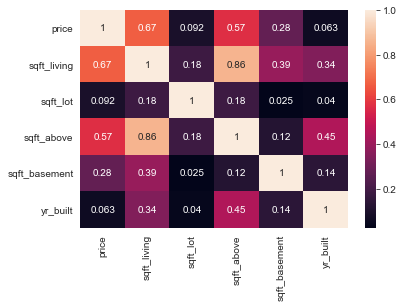

In [21]:
#Correlation among the categorical variables
corr_cont = df[continuous].corr().abs()
(corr_cont)

# Mapping the correlation among the continous variable
sns.heatmap(corr_cont, annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

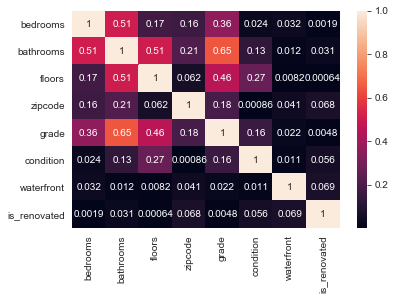

In [22]:
#Correlation among the categorical variables
corr_cat = df[categorical].corr().abs()
(corr_cat)
sns.heatmap(corr_cat, annot=True)

# Mapping the correlation among the categorical variable  
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [23]:
# Since the Multicolinearity threshold value is 0.75, 
# sqft_above shows a colinearity of greater than 0.75,
# So we drop all the features that can cause multicolinearity as it reduces us in deriving linear regression with minimal error

df=df.drop(['sqft_above','date', 'yr_renovated'],axis=1)

In [24]:
new_continuous = ['price','sqft_living','sqft_lot', 'yr_built','sqft_basement']
df_cont = df[new_continuous]
df_cat = df[categorical]

# Displaying the head of the continous data column
df_cont.head()

,price,sqft_living,sqft_lot,yr_built,sqft_basement
0,221900.0,1180,5650,1955,0.0
1,538000.0,2570,7242,1951,400.0
2,180000.0,770,10000,1933,0.0
3,604000.0,1960,5000,1965,910.0
4,510000.0,1680,8080,1987,0.0


In [25]:
# Displaying the head of the categorical data column
df_cat.head()

,bedrooms,bathrooms,floors,zipcode,grade,condition,waterfront,is_renovated
0,3,1.00,1.0,98178,7,3,0.0,0.0
1,3,2.25,2.0,98125,7,3,0.0,1.0
2,2,1.00,1.0,98028,6,3,0.0,0.0
3,4,3.00,1.0,98136,7,5,0.0,0.0
4,3,2.00,1.0,98074,8,3,0.0,0.0


In [26]:
print(df.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'is_renovated', 'b_sqft_basement', 'month_sold', 'yr_sold',
       'age', 'perc'],
      dtype='object')


In [27]:
# pd.plotting.scatter_matrix(df, figsize=(10,12));

# Normalizing the Data


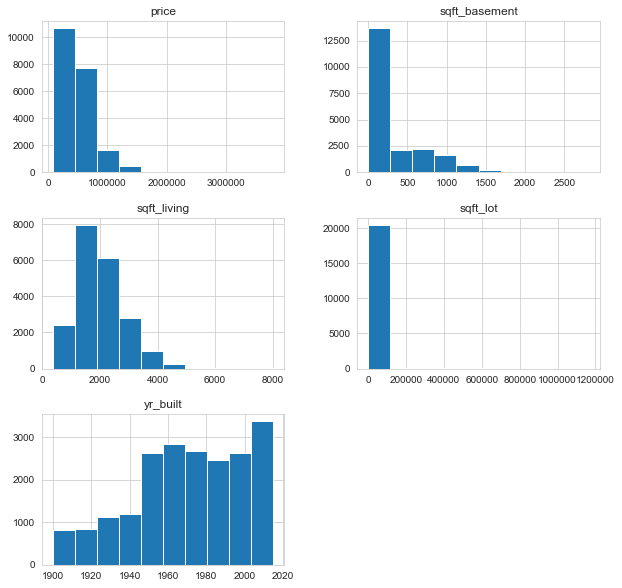

In [28]:
# Continous Variables in Non-Normal Distribution
df_cont[['price','sqft_living','sqft_lot', 'yr_built','sqft_basement']].hist(figsize  = [10,10]);


In [29]:
#Temporalily Remove the date column from the continuous variable dataframe. Though it
#is continuous, we wont be able to perform mathemtical equations with this column. We
#will add it back in later
norm_check = df_cont
norm_check.head()


,price,sqft_living,sqft_lot,yr_built,sqft_basement
0,221900.0,1180,5650,1955,0.0
1,538000.0,2570,7242,1951,400.0
2,180000.0,770,10000,1933,0.0
3,604000.0,1960,5000,1965,910.0
4,510000.0,1680,8080,1987,0.0


# Conducting the Shapiro Test

In [30]:
#Perform Shapiro Test to check for normality

import warnings #Ignore all warnings
warnings.filterwarnings("ignore")

#Conduct Shapiro Test
from scipy import stats

#Convert DataFrame columns to numpy arrays in order to input into Shapiro and KS Test Functions
sqft_lot_arr = np.array(norm_check['sqft_lot'])
sqft_base_arr = np.array(norm_check['sqft_basement'])
yr_built_arr = np.array(norm_check['yr_built'])
price_arr = np.array(norm_check['price'])
sqft_living_arr = np.array(norm_check['sqft_living'])


print('Shapiro Test sqft_lot: ', stats.shapiro(sqft_lot_arr))
print('Shapiro Test sqft_basement: ', stats.shapiro(sqft_base_arr))
print('Shapiro Test yr_built: ', stats.shapiro(yr_built_arr))
print('Shapiro Test price: ', stats.shapiro(price_arr))
print('Shapiro Test sqft_living: ', stats.shapiro(sqft_living_arr))

print('The p_values are less than 0.05 which tells us that the data is not normally distributed')

Shapiro Test sqft_lot:  (0.27807170152664185, 0.0)
Shapiro Test sqft_basement:  (0.7064201831817627, 0.0)
Shapiro Test yr_built:  (0.9563287496566772, 0.0)
Shapiro Test price:  (0.8302925229072571, 0.0)
Shapiro Test sqft_living:  (0.9488532543182373, 0.0)
The p_values are less than 0.05 which tells us that the data is not normally distributed


## Conducting K-Test

In [31]:
#Conduct KS Test
print('KS Test sqft_lot: ', stats.kstest(sqft_lot_arr, 'norm'))
print('KS Test sqft_basement: ', stats.kstest(sqft_base_arr, 'norm'))
print('KS Test yr_built: ', stats.kstest(yr_built_arr, 'norm'))
print('KS Test price: ', stats.kstest(price_arr, 'norm'))
print('KS Test price: ', stats.kstest(sqft_living_arr, 'norm'))

KS Test sqft_lot:  KstestResult(statistic=1.0, pvalue=0.0)
KS Test sqft_basement:  KstestResult(statistic=0.5, pvalue=0.0)
KS Test yr_built:  KstestResult(statistic=1.0, pvalue=0.0)
KS Test price:  KstestResult(statistic=1.0, pvalue=0.0)
KS Test price:  KstestResult(statistic=1.0, pvalue=0.0)


## Log Transformation --- Optional**

In [32]:
#Log Transformation
data_log = pd.DataFrame([])
data_log['loglot'] = np.log(norm_check['sqft_lot'])
data_log['logbase'] = np.log(norm_check['sqft_basement'])
data_log['logbuilt'] = np.log(norm_check['yr_built'])
data_log['logliving']= np.log(norm_check['sqft_living'])
data_log.head()
#Log Trans Produces '-inf' values, this will cause errors in our model

,loglot,logbase,logbuilt,logliving
0,8.639411,-inf,7.578145,7.073270
1,8.887653,5.991465,7.576097,7.851661
2,9.210340,-inf,7.566828,6.646391
3,8.517193,6.813445,7.583248,7.580700
4,8.997147,-inf,7.594381,7.426549


## Normalization with  a proper Scaling **

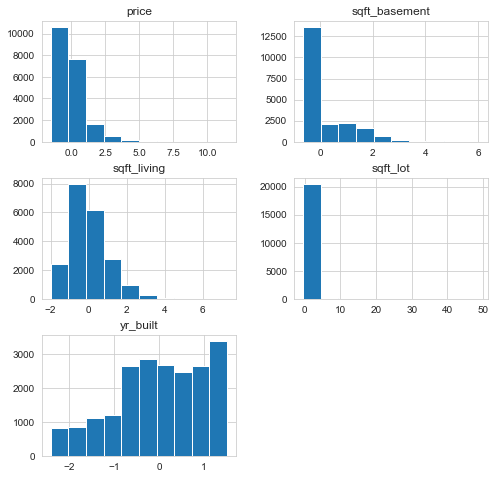

In [33]:
# Our P-value > 0.05, but we will make the data more normal to see how it impacts the model performance
#Standardization (This method DOES NOT Normalize Data)
def norm_feat(series):
    return (series - series.mean())/series.std()
for feat in norm_check.columns:
    df[feat] = norm_feat(df[feat])
# print(df.describe())

norm_df = norm_feat(norm_check)
norm_df.head()
norm_df.hist(figsize  = [8, 8]);

In [34]:
# def predict_price(x_sample):
#     cols= [#number of columns]
#     target = 'Price'
#     x_sample_final= x_sample[cols]
#     return ols.predict(x_sample_final

## Mean- Normalization of the Data ---- **Optional 

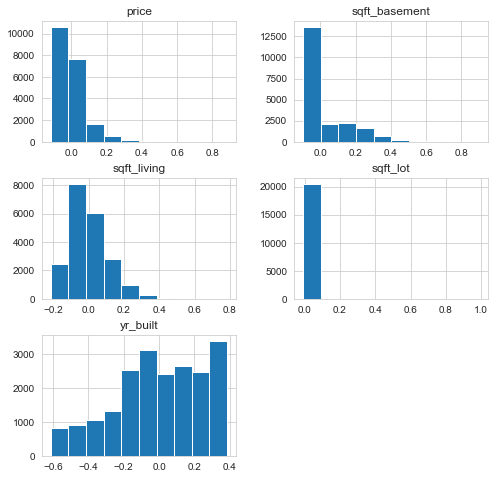

In [35]:
def mean_norm(series):
    return (series - series.mean()) / (series.max()- series.min())

top_feat = ['price','sqft_living','sqft_lot', 'yr_built','sqft_basement']
for feat in top_feat:
    df[feat] = mean_norm(df[feat])

mean_norm_df = mean_norm(norm_check)
mean_norm_df.head()
mean_norm_df.hist(figsize  = [8, 8])
plt.show()

## Creating a Dummy Variables for Categorical Problems

In [36]:
#Try treating categorical variables with Label Encoding
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
category_df = df[categorical]

cat_df = pd.DataFrame([])
cat_df['cond_dummy'] = lb_make.fit_transform(category_df.condition)
cat_df['grade_dummy'] = lb_make.fit_transform(category_df.grade)
cat_df['bed_dummy'] = lb_make.fit_transform(category_df.bedrooms)
cat_df['bath_dummy'] = lb_make.fit_transform(category_df.bathrooms)
cat_df['floor_dummy'] = lb_make.fit_transform(category_df.floors)
cat_df['zip_dummy'] = lb_make.fit_transform(category_df.zipcode)
cat_df['is_renovated'] = category_df['is_renovated']
cat_df.head()

,cond_dummy,grade_dummy,bed_dummy,bath_dummy,floor_dummy,zip_dummy,is_renovated
0,2,4,2,2,0,66,0.0
1,2,4,2,7,2,55,1.0
2,2,3,1,2,0,16,0.0
3,4,4,3,10,0,58,0.0
4,2,5,2,6,0,37,0.0


## Creating Dummies with pd.get_dummies(df,drop_first=True)

In [37]:
# Trying with the simple encoding of get_dummies
categorical = ['bedrooms', 'bathrooms', 'floors', 'zipcode', 'grade', 'condition', 'waterfront']
origin_series = pd.Series(categorical)
cat_origin = origin_series.astype('category')
# cat = df[categorical]
dummies_df = pd.get_dummies(cat_origin,drop_first=True)
dummies_df.head()

,bedrooms,condition,floors,grade,waterfront,zipcode
0,1,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0


In [38]:
#Combining Categorical and Continuous data into one dataframe

complete_df = pd.concat([cat_df, norm_df], axis=1) #drop the padded zero column that was justed to combine the 2 dataframes
complete_df.head()
normalized_df = pd.concat([norm_df,df_cat],axis=1) # values with the normalized data but not categorized.
normalized_df.head()

,price,sqft_living,sqft_lot,yr_built,sqft_basement,bedrooms,bathrooms,floors,zipcode,grade,condition,waterfront,is_renovated
0,-1.009689,-1.018884,-0.259032,-0.533608,-0.655558,3,1.00,1.0,98178,7,3,0.0,0.0
1,0.090784,0.667308,-0.191421,-0.669922,0.298808,3,2.25,2.0,98125,7,3,0.0,1.0
2,-1.155560,-1.516249,-0.074290,-1.283338,-0.655558,2,1.00,1.0,98028,6,3,0.0,0.0
3,0.320557,-0.072676,-0.286637,-0.192822,1.515626,4,3.00,1.0,98136,7,5,0.0,0.0
4,-0.006695,-0.412340,-0.155831,0.556908,-0.655558,3,2.00,1.0,98074,8,3,0.0,0.0


In [39]:
complete_df.head()

,cond_dummy,grade_dummy,bed_dummy,bath_dummy,floor_dummy,zip_dummy,is_renovated,price,sqft_living,sqft_lot,yr_built,sqft_basement
0,2.0,4.0,2.0,2.0,0.0,66.0,0.0,-1.009689,-1.018884,-0.259032,-0.533608,-0.655558
1,2.0,4.0,2.0,7.0,2.0,55.0,1.0,0.090784,0.667308,-0.191421,-0.669922,0.298808
2,2.0,3.0,1.0,2.0,0.0,16.0,0.0,-1.155560,-1.516249,-0.074290,-1.283338,-0.655558
3,4.0,4.0,3.0,10.0,0.0,58.0,0.0,0.320557,-0.072676,-0.286637,-0.192822,1.515626
4,2.0,5.0,2.0,6.0,0.0,37.0,0.0,-0.006695,-0.412340,-0.155831,0.556908,-0.655558


# Modeling the Data

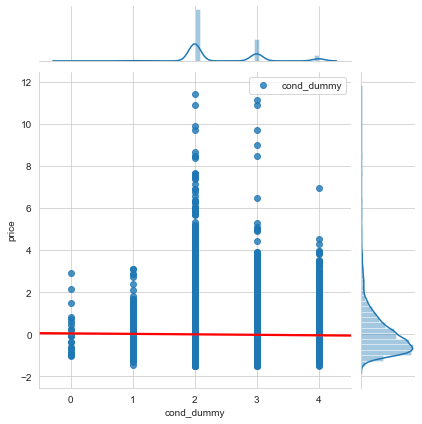

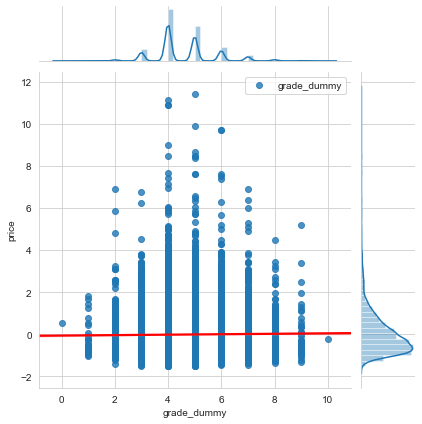

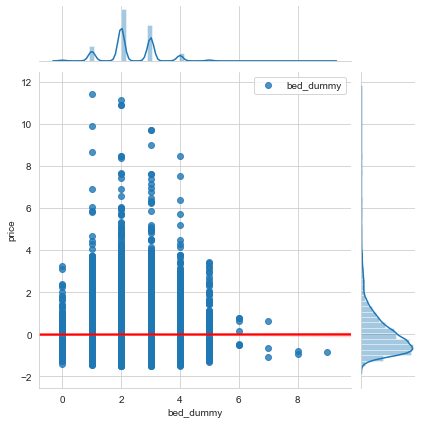

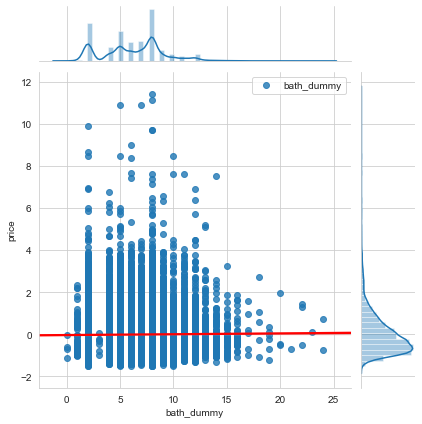

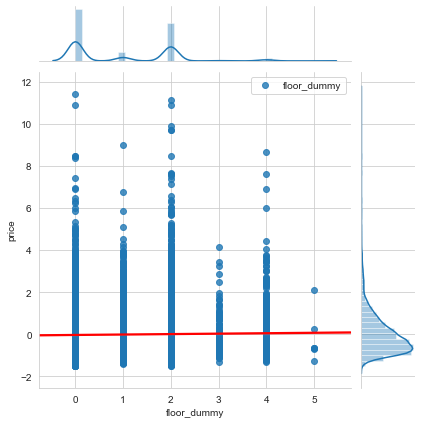

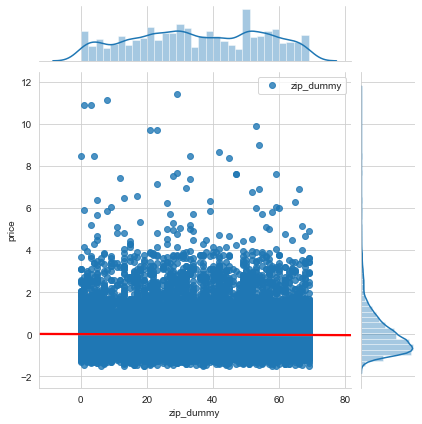

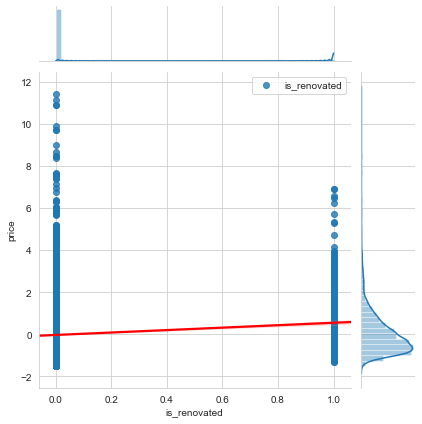

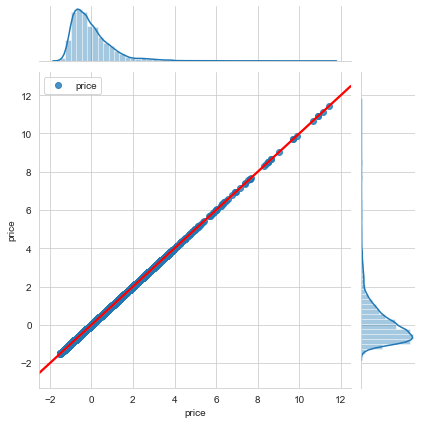

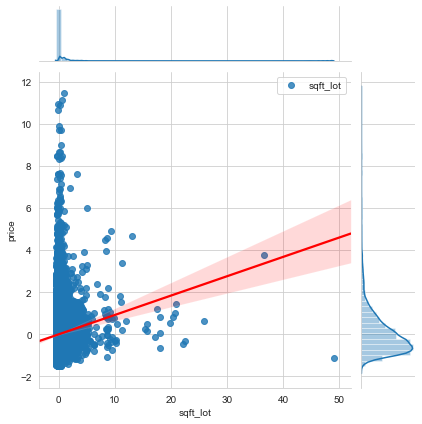

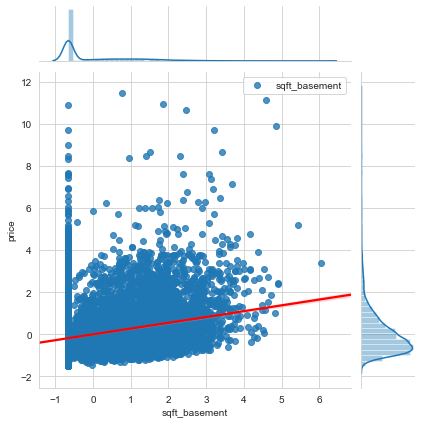

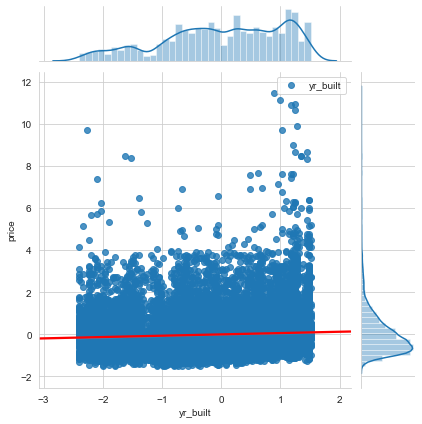

In [40]:
# Build joint plots to check for linearity assumption between predictors and target variable
for column in ['cond_dummy','grade_dummy','bed_dummy','bath_dummy','floor_dummy','zip_dummy','is_renovated',
              'price', 'sqft_lot', 'sqft_basement', 'yr_built']:
    sns.jointplot(x = column, y ='price',
                  data = complete_df, 
                  kind = 'reg', 
                  label = column,
                  joint_kws = {'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()

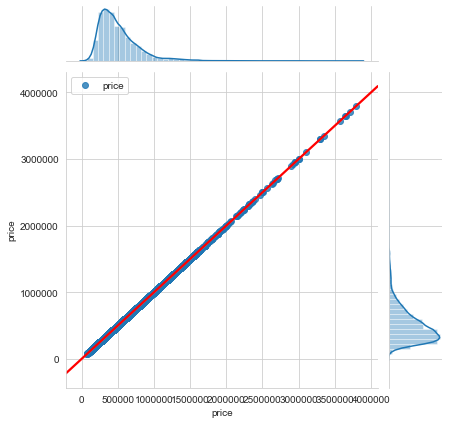

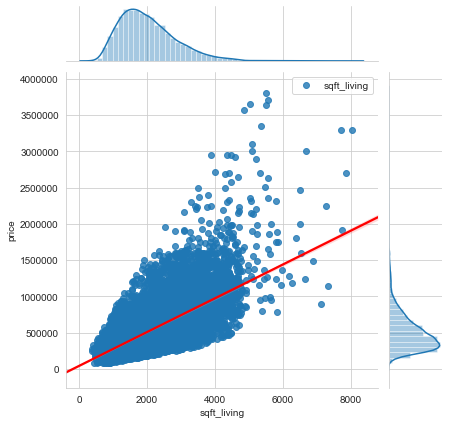

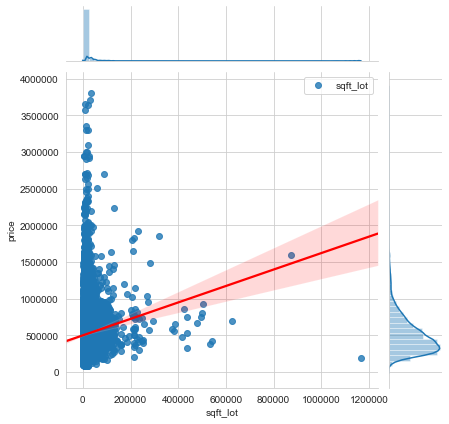

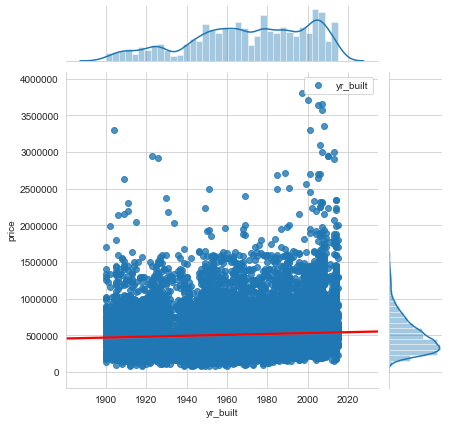

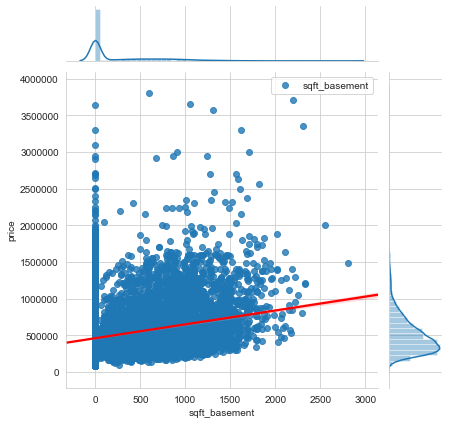

In [41]:
# Build joint plots to check for linearity assumption between predictors and target variable
for column in ['price','sqft_living','sqft_lot', 'yr_built','sqft_basement']:
    sns.jointplot(x = column, y ='price',
                  data = norm_check, 
                  kind = 'reg', 
                  label = column,
                  joint_kws = {'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()

In [42]:
def fullRegressionAnalysis(b, df, a='price'):
    '''a: str Dependent variable column name
        b: List of str Independent variable columns
        df: dataframe Dataframe to analyze
        
        First line of regression analysis between the dependent variable and a single independent variable in a dataFrame
    
        Returns
        R-squared value
        Intercept
        Slope
        P-Value
        JB Score & Probability of JB
        Statistical signfigance
        Rejection of normal distribution of errors
        Scatter plot with Line of Best Fit
        Regression plots for column2 vs. model
        QQ plot
        Model Summary Statistics'''

    
    b = df.drop(a, axis=1)
    pred_sum = '+'.join(b.columns)
    f = a+'~'+pred_sum
    model = ols(formula=f, data=df).fit()
    #print (b, 'vs.', a)
    print ('R-Squared:',model.rsquared)
    print ('Intercept:',model.params[0])
    print ('Slope:',model.params[1])
    print ('P-Value:',round(model.pvalues[1],4))
    print ('JB Score:',sms.jarque_bera(model.resid)[0], 'Probability:', sms.jarque_bera(model.resid)[1])
    if model.pvalues[1] <= 0.05:
        print(b,'HAS a statistically significant relationship to',a)
    else:
        print(b,'DOES NOT HAVE a statistically significant relationship to',a)
    if sms.jarque_bera(model.resid)[0] >= 6 and sms.jarque_bera(model.resid)[1] <= 0.05:
        print(' We REJECT the normal distribution of the model errors')
#         The code errors in this block- We'll need to trouble shootto get the rest to execute
#     X_new = pd.DataFrame({val: [df[val].min(), df[val].max()]});
#     preds = model.predict(X_new)
#     data.plot(kind='scatter', x=b, y=a, title='Line of Best Fit');
#     plt.plot(X_new, preds, c='red', linewidth=2);
#     plt.show()
#     fig = plt.figure(figsize=(15,8))
#     fig = sm.graphics.plot_regress_exog(model, b, fig=fig)
#     plt.show()
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title('QQ Plot')
    plt.show()    
    return model.summary()

# Model 1 - Normalized Data

R-Squared: 0.4829261738448607
Intercept: 5.551115123125783e-17
Slope: 0.76856106753566
P-Value: 0.0
JB Score: 111762.97153895992 Probability: 0.0
       sqft_living  sqft_lot  yr_built  sqft_basement
0        -1.018884 -0.259032 -0.533608      -0.655558
1         0.667308 -0.191421 -0.669922       0.298808
2        -1.516249 -0.074290 -1.283338      -0.655558
3        -0.072676 -0.286637 -0.192822       1.515626
4        -0.412340 -0.155831  0.556908      -0.655558
...            ...       ...       ...            ...
21592    -0.594303 -0.450952  1.306638      -0.655558
21593     0.351905 -0.252110  1.477031      -0.655558
21594    -1.212978 -0.441651  1.306638      -0.655558
21595    -0.509387 -0.397567  1.136245      -0.655558
21596    -1.212978 -0.453287  1.272559      -0.655558

[20640 rows x 4 columns] HAS a statistically significant relationship to price
 We REJECT the normal distribution of the model errors


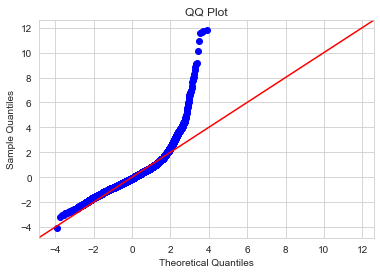

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     4818.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:56:18   Log-Likelihood:                -22480.
No. Observations:               20640   AIC:                         4.497e+04
Df Residuals:                   20635   BIC:                         4.501e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.551e-17      0.005   1.11e-14      1.000      -0.010       0.010
sqft_living       0.7686      0.006    124.750      0.000       0.756       0.781
sqft_lot         -0.0390      0.005     -7.640      0.000      -0.049      -0.029
yr_built         -0.2067      0.006    -36.766      0.000      -0.218      -0.196
sqft_basement    -0.0540      0.006     -9.394      0.000      -0.065      -0.043
==============================================================================
Omnibus:                     8971.278   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111762.972
Skew:                           1.752   Prob(JB):                         0.00
Kurtosis:                      13.848   Cond. No.                         1.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# Full Regression Analysis on Normalized data
a='price'
b=['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']
fullRegressionAnalysis(a=a,b=b, df=norm_df)

# ## Full Refression Analysis on Mean Normalized
# a='price'
# b=['price','sqft_living', 'sqft_lot', 'sqft_basement', 'yr_built']
# fullRegressionAnalysis(a=a,b=b, df=mean_norm_df)
#----------------------------------------------------------------------
# The above for mean normalized will give out the same result as Normalized Data

# Model 2 - Normalized data with Label Encoder

R-Squared: 0.4857150499240379
Intercept: 0.03319231920021888
Slope: -0.00893528281387445
P-Value: 0.2677
JB Score: 97361.65161193252 Probability: 0.0
       cond_dummy  grade_dummy  bed_dummy  bath_dummy  floor_dummy  zip_dummy  \
0             2.0          4.0        2.0         2.0          0.0       66.0   
1             2.0          4.0        2.0         7.0          2.0       55.0   
2             2.0          3.0        1.0         2.0          0.0       16.0   
3             4.0          4.0        3.0        10.0          0.0       58.0   
4             2.0          5.0        2.0         6.0          0.0       37.0   
...           ...          ...        ...         ...          ...        ...   
21592         NaN          NaN        NaN         NaN          NaN        NaN   
21593         NaN          NaN        NaN         NaN          NaN        NaN   
21594         NaN          NaN        NaN         NaN          NaN        NaN   
21595         NaN          NaN        Na

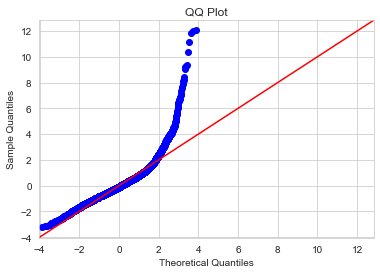

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     1693.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:56:19   Log-Likelihood:                -21130.
No. Observations:               19732   AIC:                         4.228e+04
Df Residuals:                   19720   BIC:                         4.238e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0332      0.034      0.963      0.336      -0.034       0.101
cond_dummy       -0.0089      0.008     -1.108      0.268      -0.025       0.007
grade_dummy       0.0022      0.006      0.360      0.719      -0.010       0.014
bed_dummy        -0.0069      0.007     -1.018      0.309      -0.020       0.006
bath_dummy       -0.0043      0.003     -1.653      0.098      -0.010       0.001
floor_dummy       0.0165      0.006      2.881      0.004       0.005       0.028
zip_dummy        -0.0003      0.000     -1.238      0.216      -0.001       0.000
is_renovated      0.2077      0.028      7.310      0.000       0.152       0.263
sqft_living       0.7704      0.006    121.615      0.000       0.758       0.783
sqft_lot         -0.0415      0.005     -8.014      0.000      -0.052      -0.031
yr_built         -0.2165      0.006    -36.578      0.000      -0.228      -0.205
sqft_basement    -0.0615      0.006    -10.684      0.000      -0.073      -0.050
==============================================================================
Omnibus:                     8216.574   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97361.652
Skew:                           1.673   Prob(JB):                         0.00
Kurtosis:                      13.355   Cond. No.                         286.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Full Refression Analysis on Normalized Data with dummies
a='price'
b=['sqft_living', 'sqft_lot', 'sqft_basement', 'yr_built']
fullRegressionAnalysis(a=a,b=b, df=complete_df)

# Model 3 - Normalized Data with Trimmed features

R-Squared: 0.6004283252901248
Intercept: -3.386457690373182
Slope: 0.3814354046334673
P-Value: 0.0
JB Score: 172363.12876335642 Probability: 0.0
       sqft_living  yr_built  bedrooms  bathrooms  grade  is_renovated
0        -1.018884 -0.533608         3       1.00      7           0.0
1         0.667308 -0.669922         3       2.25      7           1.0
2        -1.516249 -1.283338         2       1.00      6           0.0
3        -0.072676 -0.192822         4       3.00      7           0.0
4        -0.412340  0.556908         3       2.00      8           0.0
...            ...       ...       ...        ...    ...           ...
21592    -0.594303  1.306638         3       2.50      8           0.0
21593     0.351905  1.477031         4       2.50      8           0.0
21594    -1.212978  1.306638         2       0.75      7           0.0
21595    -0.509387  1.136245         3       2.50      8           0.0
21596    -1.212978  1.272559         2       0.75      7           0.0

[2

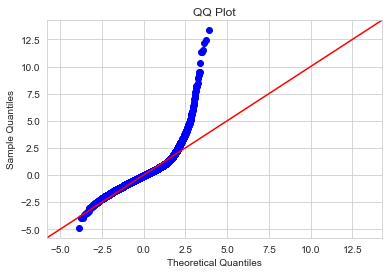

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     5167.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:56:20   Log-Likelihood:                -19819.
No. Observations:               20640   AIC:                         3.965e+04
Df Residuals:                   20633   BIC:                         3.971e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.3865      0.057    -59.012      0.000      -3.499      -3.274
sqft_living      0.3814      0.009     44.661      0.000       0.365       0.398
yr_built        -0.3523      0.006    -62.577      0.000      -0.363      -0.341
bedrooms        -0.1157      0.007    -17.761      0.000      -0.128      -0.103
bathrooms        0.1929      0.010     18.741      0.000       0.173       0.213
grade            0.4435      0.006     69.213      0.000       0.431       0.456
is_renovated     0.0614      0.026      2.396      0.017       0.011       0.112
==============================================================================
Omnibus:                     9971.605   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           172363.129
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      16.637   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
dropped=normalized_df.drop(['floors','sqft_lot','sqft_basement','floors','zipcode','condition','waterfront'],axis=1)
# Full Refression Analysis on Normalized Data
a='price'
b=['sqft_living', 'sqft_lot', 'sqft_basement', 'yr_built']
fullRegressionAnalysis(a=a,b=b, df=dropped)

# Model 4 --  All Features

R-Squared: 0.619186477437235
Intercept: -0.040075048378191716
Slope: -0.007864715744870316
P-Value: 0.0
JB Score: 179077.14416367662 Probability: 0.0
       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0             3       1.00    -0.109792 -0.005239     1.0         0.0   
1             3       2.25     0.071907 -0.003871     2.0         0.0   
2             2       1.00    -0.163387 -0.001502     1.0         0.0   
3             4       3.00    -0.007831 -0.005797     1.0         0.0   
4             3       2.00    -0.044433 -0.003152     1.0         0.0   
...         ...        ...          ...       ...     ...         ...   
21592         3       2.50    -0.064040 -0.009120     3.0         0.0   
21593         4       2.50     0.037920 -0.005099     2.0         0.0   
21594         2       0.75    -0.130707 -0.008932     2.0         0.0   
21595         3       2.50    -0.054890 -0.008040     2.0         0.0   
21596         2       0.75    -0.130707 -0.0091

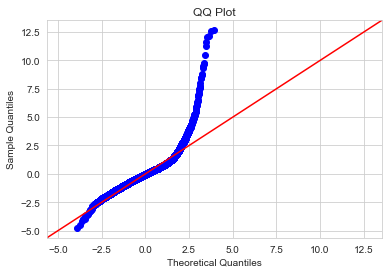

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2096.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:56:20   Log-Likelihood:                 33550.
No. Observations:               20640   AIC:                        -6.707e+04
Df Residuals:                   20623   BIC:                        -6.693e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0401      0.008     -4.896      0.000      -0.056      -0.024
bedrooms           -0.0079      0.000    -15.839      0.000      -0.009      -0.007
bathrooms           0.0098      0.001     11.795      0.000       0.008       0.011
sqft_living         0.2865      0.007     42.366      0.000       0.273       0.300
sqft_lot            0.0167      0.018      0.922      0.357      -0.019       0.052
floors              0.0061      0.001      6.939      0.000       0.004       0.008
waterfront          0.1128      0.005     21.474      0.000       0.102       0.123
condition           0.0056      0.001      9.904      0.000       0.005       0.007
grade               0.0333      0.000     66.776      0.000       0.032       0.034
sqft_basement       0.0002      0.005      0.037      0.971      -0.009       0.010
yr_built            0.6867      0.140      4.896      0.000       0.412       0.962
zipcode         -4.468e-06   7.06e-06     -0.633      0.527   -1.83e-05    9.37e-06
is_renovated        0.0050      0.002      2.542      0.011       0.001       0.009
b_sqft_basement     0.0039      0.001      2.930      0.003       0.001       0.006
month_sold       4.476e-05      0.000      0.261      0.794      -0.000       0.000
yr_sold          -2.47e-05      0.000     -0.070      0.944      -0.001       0.001
age                 0.0069      0.001      5.635      0.000       0.004       0.009
perc               -0.0601      0.004    -15.682      0.000      -0.068      -0.053
==============================================================================
Omnibus:                     9978.526   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           179077.144
Skew:                           1.890   Prob(JB):                         0.00
Kurtosis:                      16.926   Cond. No.                     4.05e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.21e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
# Full Refression Analysis on all features

a='price'
b=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'month_sold',
       'yr_sold', 'age', 'perc', 'is_renovated']

fullRegressionAnalysis(a=a,b=b, df=df)

# Model 5 -- Features with Low P-value

In [47]:
df_lowp = df.drop(['sqft_lot', 'sqft_basement', 'month_sold', 'zipcode','b_sqft_basement','is_renovated'], axis=1)
df_lowp.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'condition', 'grade', 'yr_built', 'yr_sold', 'age', 'perc'],
      dtype='object')

R-Squared: 0.6186187379155024
Intercept: -0.03962459081957461
Slope: -0.007967255170990232
P-Value: 0.0
JB Score: 174764.26141788522 Probability: 0.0
       bedrooms  bathrooms  sqft_living  floors  waterfront  condition  grade  \
0             3       1.00    -0.109792     1.0         0.0          3      7   
1             3       2.25     0.071907     2.0         0.0          3      7   
2             2       1.00    -0.163387     1.0         0.0          3      6   
3             4       3.00    -0.007831     1.0         0.0          5      7   
4             3       2.00    -0.044433     1.0         0.0          3      8   
...         ...        ...          ...     ...         ...        ...    ...   
21592         3       2.50    -0.064040     3.0         0.0          3      8   
21593         4       2.50     0.037920     2.0         0.0          3      8   
21594         2       0.75    -0.130707     2.0         0.0          3      7   
21595         3       2.50    -0.054890 

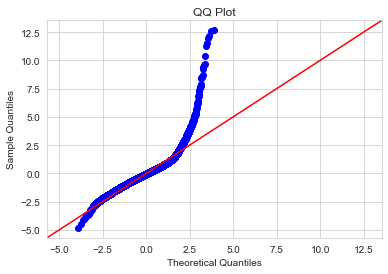

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     3346.
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        23:56:21   Log-Likelihood:                 33535.
No. Observations:               20640   AIC:                        -6.705e+04
Df Residuals:                   20629   BIC:                        -6.696e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0396      0.005     -8.153      0.000      -0.049      -0.030
bedrooms       -0.0080      0.000    -16.151      0.000      -0.009      -0.007
bathrooms       0.0109      0.001     13.523      0.000       0.009       0.012
sqft_living     0.2919      0.006     47.877      0.000       0.280       0.304
floors          0.0046      0.001      5.828      0.000       0.003       0.006
waterfront      0.1139      0.005     21.746      0.000       0.104       0.124
condition       0.0055      0.001      9.872      0.000       0.004       0.007
grade           0.0332      0.000     67.486      0.000       0.032       0.034
yr_built        0.6790      0.083      8.153      0.000       0.516       0.842
yr_sold        -0.0002   1.37e-05    -17.438      0.000      -0.000      -0.000
age             0.0068      0.001      9.412      0.000       0.005       0.008
perc           -0.0618      0.003    -17.784      0.000      -0.069      -0.055
==============================================================================
Omnibus:                     9904.007   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174764.261
Skew:                           1.877   Prob(JB):                         0.00
Kurtosis:                      16.752   Cond. No.                     8.08e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [48]:
#Run Model with features whose p_values are less than 0.05

a = 'price'
b = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'condition', 'grade', 'yr_built', 'yr_sold', 'age','perc']

fullRegressionAnalysis(a=a, b=b, df=df_lowp)

# Final Model

In [49]:
# Model Validation
y = df_lowp[['price']]
X =df_lowp.drop(['price'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

13828 6812 13828 6812


In [50]:
# Run the same model in Scikit-learn
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Train-Test Split using Sklearn
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.002291393923635244
Test Mean Squarred Error: 0.0022342573020651866


In [51]:
# Analyze coefficients in Sklearn
linreg.coef_

array([[-7.60186700e-03,  1.07876911e-02,  2.94073375e-01,
         4.82219311e-03,  1.22888966e-01,  6.18455923e-03,
         3.32456287e-02,  4.02736448e-05,  5.54923310e-03,
         9.17763953e-04, -6.87124031e-02]])

In [52]:
def kfolds(df, k):
    """ Splits a dataframe into k evenly sized pieces. If the full 
        dataset is not divisible by k, kfolds makes
        the first few folds one (+1) larger then later folds.
    """
    num_observations = len(df)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds

In [53]:
def get_errors(folds, k):
    """
    Performs linear regression on each fold and 
    calculates the training and test error
    """
    test_errs = []
    train_errs = []


    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i, fold in enumerate(df_lowp_fold) if i!=n])
        test = df_lowp_fold[n]
        # Fit a linear regression model
        linreg.fit(X_train, y_train)
        #Evaluate Train and Test Errors
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_residuals = y_hat_train - y_train
        test_residuals = y_hat_test - y_test
        train_errs.append(np.mean(train_residuals.astype(float)**2))
        test_errs.append(np.mean(test_residuals.astype(float)**2))
    print(train_errs)
    print(test_errs)

In [54]:
# 5 Folds; k=5
df_lowp_fold = kfolds(df=df_lowp, k=5)
five_fold = get_errors(folds=df_lowp_fold, k=5)

[price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64]
[price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64]


In [55]:
# 10 Folds; k=10

df_lowp_fold = kfolds(df=df_lowp, k=10)
ten_fold = get_errors(folds=df_lowp_fold, k=10)

[price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64]
[price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64]


In [56]:
# 20 Folds; k=20
df_lowp_fold = kfolds(df=df_lowp, k=20)
ten_fold = get_errors(folds=df_lowp_fold, k=20)

[price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64, price    0.002291
dtype: float64]
[price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.002234
dtype: float64, price    0.0

In [57]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

print('5-Fold Cross-Validation: ' ,cv_5_results)
print('10-Fold Cross-Validation: ' ,cv_10_results)
print('20-Fold Cross-Validation: ' ,cv_10_results)

5-Fold Cross-Validation:  -0.002328171097847981
10-Fold Cross-Validation:  -0.0022998705209760135
20-Fold Cross-Validation:  -0.0022998705209760135


[[-0.02775855]
 [-0.02775855]
 [-0.07404897]
 ...
 [-0.02775855]
 [ 0.01853187]
 [-0.02775855]]


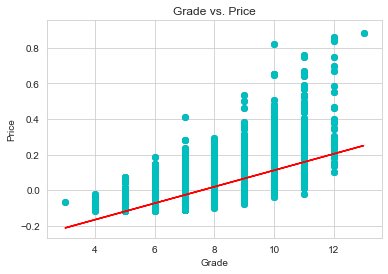

In [58]:
# Prediction of Price with Grade

y = df_lowp[['price']]
x =df_lowp.grade

Y = y.to_numpy().reshape(-1, 1)
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions
print(Y_pred)
plt.scatter(X, Y)
plt.title('Grade vs. Price')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.scatter(X, Y, c='c')
plt.plot(X, Y_pred, label='Line of Best Fit', color='red')
plt.show()

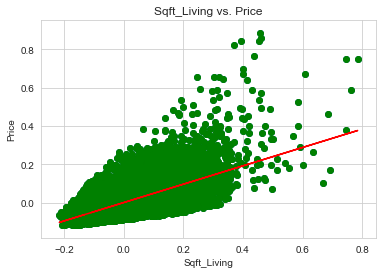

In [59]:
# Prediction of Price with Sqft_living

y = df_lowp[['price']]
x =df_lowp.sqft_living

Y = y.to_numpy().reshape(-1, 1)
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions

plt.scatter(X, Y)
plt.title('Sqft_Living vs. Price')
plt.xlabel('Sqft_Living')
plt.ylabel('Price')
plt.scatter(X, Y, c ='g')
plt.plot(X, Y_pred, label='Line of Best Fit', color='red')
plt.show()

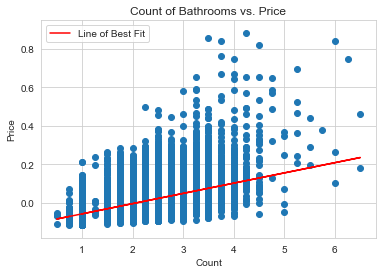

In [60]:
#Regression Line Yr_built vs. Price

y = df_lowp[['price']]
x =df_lowp.bathrooms

Y = y.to_numpy().reshape(-1, 1)
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions

plt.title('Count of Bathrooms vs. Price')
plt.xlabel('Count')
plt.ylabel('Price')
plt.scatter(X, Y)
plt.plot(X, Y_pred, label='Line of Best Fit', color='red')
plt.legend()
plt.show()

## Perform Recursive Feature Elimination to Determine the Most Important Features for a Model

In [61]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

predictors = df.drop('price', axis=1)
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=5)
selector = selector.fit(predictors, df['price'])

In [62]:
selector.support_ #'True' indicates the selected features


array([False, False,  True, False, False,  True, False,  True, False,
       False, False,  True, False, False, False, False,  True])

In [63]:
selector.ranking_

array([ 5,  4,  1,  6,  8,  1,  2,  1, 10, 12, 13,  1,  3, 11,  7,  9,  1])

In [64]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

NameError: name 'model' is not defined

<Figure size 1080x576 with 0 Axes>